# 3. Cell Type Annotation using a Pre-Trained Cell2Sentence Model

In this notebook, we'll:
1. Load a pre-trained C2S model from the HuggingFace Hub.
2. Use the model to predict cell types based on our generated cell sentences.
3. Integrate these predictions back into AnnData.

## Learning Objectives
- Learn how to load a pre-trained LLM for single-cell data.
- Automatically annotate PBMC cells.
- Assess annotation quality by comparing known marker genes.

In [1]:
import torch
import os
import random
import numpy as np

# Cell2Sentence imports
import cell2sentence as cs

# Single-cell libraries
import anndata
import scanpy as sc

import tqdm as notebook_tqdm

/home/pieterdb/anaconda3/envs/cell2sentence_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)

In [3]:
DATA_PATH = "./data/pbmc3k_final.h5ad"
adata = anndata.read_h5ad(DATA_PATH)

In [4]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'cell_type', 'organism'
    var: 'n_cells'
    uns: 'cell_type_colors', 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_draw_graph_fr', 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

### Converting to Cell2Sentence (CSData)

In [5]:
adata_obs_cols_to_keep = ["cell_type","organism"]

In [6]:
# Create CSData object
arrow_ds, vocabulary = cs.CSData.adata_to_arrow(
    adata=adata, 
    random_state=SEED, 
    sentence_delimiter=' ',
    label_col_names=adata_obs_cols_to_keep
)

100%|██████████| 2638/2638 [00:00<00:00, 17075.70it/s]


In [7]:
arrow_ds

Dataset({
    features: ['cell_name', 'cell_sentence', 'cell_type', 'organism'],
    num_rows: 2638
})

For this exercise we will consider the top 100 genes of the cell sentences

In [8]:
k = 100  # replace with your desired number of genes

arrow_ds = arrow_ds.map(lambda x: {"cell_sentence": " ".join(x["cell_sentence"].split()[:k])})

Map: 100%|██████████| 2638/2638 [00:00<00:00, 42279.13 examples/s]


In [9]:
sample_idx = 2000
len(arrow_ds[sample_idx]['cell_sentence'].split())

100

In [10]:
c2s_save_dir = "./c2s_api_testing"  # C2S dataset will be saved into this directory
c2s_save_name = "PBMC_3K_tutorial2"  # This will be the name of our C2S dataset on disk

In [11]:
cs_data = cs.CSData.csdata_from_arrow(
    arrow_dataset=arrow_ds, 
    vocabulary=vocabulary,
    save_dir=c2s_save_dir,
    save_name=c2s_save_name,
    dataset_backend="arrow"
)

Saving the dataset (1/1 shards): 100%|██████████| 2638/2638 [00:00<00:00, 361752.89 examples/s]


In [12]:
#dir(cs_data)

In [13]:
#cs_data.get_sentence_strings()

## 3.1. Load a Pre-trained Model
We can specify a model from the Hugging Face Hub. For a smaller/faster model:
```
model_name = "vandijklab/pythia-160m-c2s"
```
For a more powerful ~410M parameter model:
```
model_name = "vandijklab/C2S-Pythia-410m-cell-type-prediction"
```

In [14]:
#model_name = "vandijklab/pythia-160m-c2s"
model_name = "vandijklab/C2S-Pythia-410m-cell-type-prediction"

save_dir = "models"  # local folder to store the downloaded model

cs_model = cs.csmodel.CSModel(
    model_name,
    save_dir=save_dir,
    save_name="cs_model"
)
print("Model loaded successfully.")

Using device: cuda
Model loaded successfully.


## 3.2. Predict Cell Types
We'll use a built-in function to predict labels for our dataset. This function will take each cell's top genes (as a sentence) and produce a text label for the cell type.

Note: This step can take a few minutes if you're on CPU, but the 160M model is typically manageable.

In [15]:
# Ensure the 'organism' key is provided if required by the function
pred_labels = cs.tasks.predict_cell_types_of_data(
    cs_data,
    cs_model,
    n_genes=100,  # must match how we created the sentences
)
pred_labels[:10]

Reloading model from path on disk: models/cs_model
Predicting cell types for 2638 cells using CSModel...


100%|██████████| 2638/2638 [02:53<00:00, 15.20it/s]


['neutrophil.',
 'CD4-positive, alpha-beta T cell.',
 'T cell.',
 'neutrophil.',
 'natural killer cell.',
 'plasma cell.',
 'natural killer cell.',
 'CD8-positive, alpha-beta T cell.',
 'natural killer cell.',
 'monocyte.']

In [16]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'cell_type', 'organism'
    var: 'n_cells'
    uns: 'cell_type_colors', 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_draw_graph_fr', 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

We have a list of cell type predictions for each cell. Let's store them in the AnnData object.

In [17]:
# Use the existing AnnData object loaded earlier (from DATA_PATH)

adata.obs['C2S_predicted_celltype'] = pred_labels
adata.obs['C2S_predicted_celltype'].value_counts()

C2S_predicted_celltype
neutrophil.                                            437
natural killer cell.                                   410
macrophage.                                            300
B cell.                                                241
CD8-positive, alpha-beta T cell.                       143
plasma cell.                                           138
endothelial cell.                                      128
CD4-positive, alpha-beta T cell.                       123
erythroblast.                                          119
innate lymphoid cell.                                   98
monocyte.                                               89
epithelial cell of lower respiratory tract.             78
malignant cell.                                         64
classical monocyte.                                     58
T cell.                                                 42
epithelial cell.                                        25
platelet.                        

Check the distribution of predicted cell types. For PBMC data, you might see T cell subsets, B cells, monocytes, etc.

## 3.3. Inspect Example Predictions
We can pick a few cells of a predicted type and look at their top genes. For example, if the model predicted `NK cell` for cell index 1, let's see if `NKG7, GZMB, PRF1` are indeed at the top.

In [18]:
cell_idx = 1773  # arbitrary example
predicted_type = adata.obs['C2S_predicted_celltype'][cell_idx]
print("Cell index:", cell_idx)
print("Predicted type:", predicted_type)
cell_type = adata.obs["cell_type"][cell_idx]
print("Cell type:\n", cell_type)

Cell index: 1773
Predicted type: natural killer cell.
Cell type:
 CD8 T cells


In [19]:
SAVE_PATH = "./data/pbmc3k_410m_predictions.h5ad"

In [20]:
adata.write_h5ad(SAVE_PATH)

In [21]:
adata.obs.head(50)

,n_genes,percent_mito,n_counts,cell_type,organism,C2S_predicted_celltype
index,,,,,,
AAACATACAACCAC-1,781,0.030178,2419.0,CD4 T cells,Homo sapiens,neutrophil.
AAACATTGAGCTAC-1,1352,0.037936,4903.0,B cells,Homo sapiens,"CD4-positive, alpha-beta T cell."
AAACATTGATCAGC-1,1131,0.008897,3147.0,CD4 T cells,Homo sapiens,T cell.
AAACCGTGCTTCCG-1,960,0.017431,2639.0,CD14+ Monocytes,Homo sapiens,neutrophil.
AAACCGTGTATGCG-1,522,0.012245,980.0,NK cells,Homo sapiens,natural killer cell.
AAACGCACTGGTAC-1,782,0.016644,2163.0,CD8 T cells,Homo sapiens,plasma cell.
AAACGCTGACCAGT-1,783,0.038161,2175.0,CD8 T cells,Homo sapiens,natural killer cell.
AAACGCTGGTTCTT-1,790,0.030973,2260.0,CD8 T cells,Homo sapiens,"CD8-positive, alpha-beta T cell."
AAACGCTGTAGCCA-1,533,0.011765,1275.0,CD4 T cells,Homo sapiens,natural killer cell.


Compare the top genes in the sentence with known markers for that predicted type. This is a quick validation that the model is leveraging real biological signals.

## Exercise:
1. Select different cells from `adata.obs['C2S_predicted_celltype']` categories.
2. Check if the top genes match known marker genes for that type.
3. Generate a UMAP (by standard scRNA-seq workflow) and color cells by predicted labels to visualize.


### (Optional) UMAP Visualization
Let's do a quick typical scRNA-seq analysis to see how predicted labels cluster.


/home/pieterdb/anaconda3/envs/cell2sentence_env/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
/home/pieterdb/anaconda3/envs/cell2sentence_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


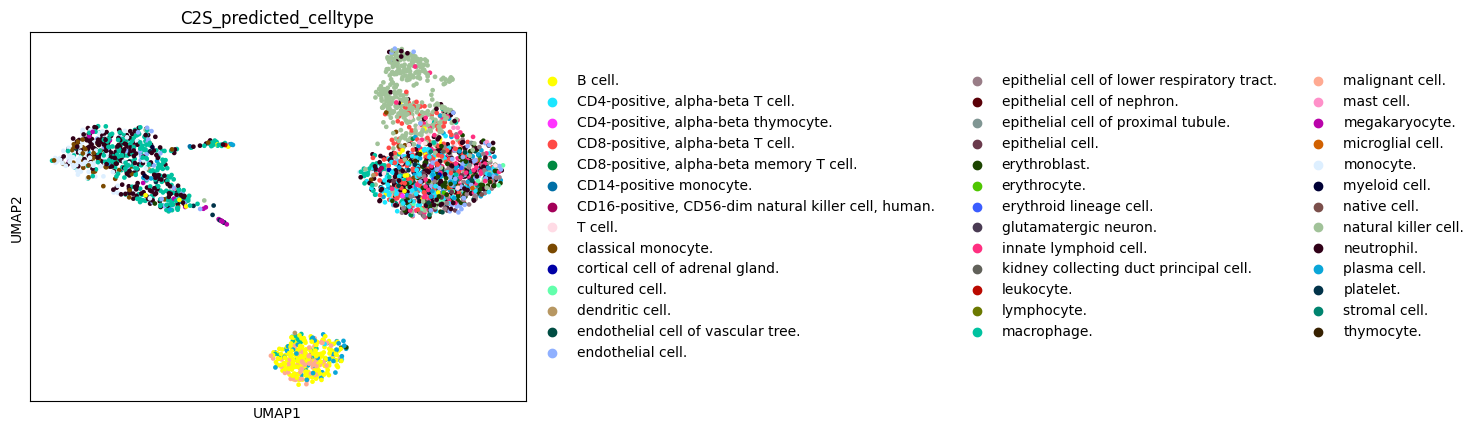

In [22]:
# Filtered data is already in adata.
# We'll do a standard pipeline: log-transform, PCA, neighbors, UMAP.
#sc.pp.normalize_total(adata, target_sum=1e4)
#sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:, adata.var.highly_variable]

sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata)

sc.pl.umap(adata, color=["C2S_predicted_celltype"], wspace=0.4, ncols=1)


You should see clusters that (hopefully) align with typical PBMC subsets. The predicted labels from the LLM can be visually inspected on the UMAP plot.

## Next Steps
[Go to Notebook 4 →](./4_Finetuning_on_New_Datasets.ipynb) to learn about generating synthetic cells, fine-tuning, and more advanced use cases.